In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv
from torch_geometric.loader import DataLoader
from scipy.spatial import cKDTree
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

In [2]:
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
##################################################
# 1. PARSE TSP FILE (PER-INSTANCE x_mid, y_mid)
##################################################

def parse_tsp_file(file_path):
    """
    Reads a .txt file where each line represents an N-city TSP instance.
    Format (single line):
      x1 y1 x2 y2 ... xN yN output r1 r2 ... rN r1

    Returns list of dict, each containing:
      - 'points': list of (x,y)
      - 'solution_edges': set((u,v)) 0-based edges
      - 'x_mid', 'y_mid': medians for that instance
    """
    instances = []
    print(f"Parsing file: {file_path}")
    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in tqdm(lines, desc="Parsing lines"):
        parts = line.strip().split()
        if "output" not in parts:
            continue

        output_index = parts.index("output")
        coord_values = parts[:output_index]
        route_values = parts[output_index + 1:]

        if len(coord_values) % 2 != 0:
            raise ValueError("Number of coordinate values must be even (x, y pairs).")

        N = len(coord_values) // 2
        points = [(float(coord_values[2*i]), float(coord_values[2*i+1])) for i in range(N)]

        x_mid = np.median([p[0] for p in points])
        y_mid = np.median([p[1] for p in points])

        route = list(map(int, route_values))
        if len(route) != N + 1 or route[0] != route[-1]:
            raise ValueError("Route must have N+1 entries and start/end with the same city.")

        sol_edges = set()
        for i in range(len(route) - 1):
            u = route[i] - 1
            v = route[i+1] - 1
            if not (0 <= u < N and 0 <= v < N):
                raise ValueError(f"Invalid route index {u},{v}. Must be between 1 and N.")
            if u != v:
                sol_edges.add((u, v))

        instances.append({
            'points': points,
            'solution_edges': sol_edges,
            'x_mid': x_mid,
            'y_mid': y_mid
        })
    return instances


In [4]:
##################################################
# 2. HELPER FUNCTIONS
##################################################

def quadrant(x, y, x_mid, y_mid):
    # Q0: x >= x_mid, y >= y_mid
    # Q1: x <  x_mid, y >= y_mid
    # Q2: x <  x_mid, y <  y_mid
    # Q3: x >= x_mid, y <  y_mid
    if x >= x_mid and y >= y_mid:
        return 0
    elif x < x_mid and y >= y_mid:
        return 1
    elif x < x_mid and y < y_mid:
        return 2
    else:
        return 3

def build_kd_tree(points):
    return cKDTree(points)

def get_k_neighbors(tree, query_point, k):
    dist, idx = tree.query(query_point, k=k)
    if k == 1:
        idx = np.array([idx])
        dist = np.array([dist])
    return dist, idx

def compute_instance_thresholds(points, x_mid, y_mid, percentile=20):
    """
    For axis closeness:
      d_x, d_y = percentile-based thresholds for |x - x_mid| and |y - y_mid|.
    """
    dx_vals = [abs(x - x_mid) for (x,y) in points]
    dy_vals = [abs(y - y_mid) for (x,y) in points]
    d_x = np.percentile(dx_vals, percentile)
    d_y = np.percentile(dy_vals, percentile)
    return d_x, d_y

def is_axis_close(x, y, x_mid, y_mid, d_x, d_y):
    return (abs(x - x_mid) <= d_x) or (abs(y - y_mid) <= d_y)

In [5]:
##################################################
# 3. DISTANCE-BASED EDGE PRUNING: PERCENTILE THRESHOLD
##################################################

def compute_instance_dist_threshold(points, x_mid, y_mid, d_x, d_y, percentile=90):
    """
    1) Identify axis-close points (just as in build_graph_instance).
    
    2) Collect all pairwise distances among these axis-close points
       (if that set is large, be mindful of O(N^2) complexity).
    3) Return the distance at the specified percentile. 
       e.g., 90 => skip edges above the 90th percentile distance.
    """
    # Step A: basic axis closeness
    axis_close_mask = [
        is_axis_close(x, y, x_mid, y_mid, d_x, d_y)
        for (x,y) in points
    ]
    axis_close_indices = [i for i,flag in enumerate(axis_close_mask) if flag]

    # If no axis-close points, return a large threshold to avoid
    # pruning everything
    if len(axis_close_indices) < 2:
        return float('inf')  # no distance-based pruning possible

    coords = np.array(points)
    axis_close_coords = coords[axis_close_indices]  # shape (M,2)

    # Step B: gather pairwise distances (O(M^2))
    dist_list = []
    M = axis_close_coords.shape[0]
    for i in range(M):
        for j in range(i+1, M):
            dx = axis_close_coords[j,0] - axis_close_coords[i,0]
            dy = axis_close_coords[j,1] - axis_close_coords[i,1]
            dist_ij = np.sqrt(dx*dx + dy*dy)
            dist_list.append(dist_ij)

    if len(dist_list) == 0:
        return float('inf')

    # Step C: percentile
    dist_threshold = np.percentile(dist_list, percentile)
    return dist_threshold


In [6]:
##################################################
# 4. BUILD GRAPH (k-NN + Dist Threshold)
##################################################

def build_graph_instance(points, 
                         x_mid, y_mid, 
                         d_x, d_y, 
                         k=3,
                         solution_edges=None,
                         add_solution_edges = False,
                         dist_threshold=float('inf')):
    """
    This function prunes edges in two ways:
      1) Only consider axis-close points as sources (plus endpoints of cross-quadrant solution edges).
      2) Among the k-NN in each quadrant, skip any edge with dist > dist_threshold.
    """
    coords = np.array(points)
    N = len(points)

    quads = [quadrant(x, y, x_mid, y_mid) for (x,y) in points]

    # Identify axis-close points
    axis_close_mask = [
        is_axis_close(x, y, x_mid, y_mid, d_x, d_y)
        for (x,y) in points
    ]

    # Enforce solution cross-quadrant edges
    if solution_edges is not None and add_solution_edges is True:
        for (u, v) in solution_edges:
            if quads[u] != quads[v]:
                axis_close_mask[u] = True
                axis_close_mask[v] = True

    axis_close_indices = np.where(axis_close_mask)[0]

    # kd-trees per quadrant
    quad_points = [[] for _ in range(4)]
    quad_indices = [[] for _ in range(4)]
    for i, (x,y) in enumerate(points):
        Q = quads[i]
        quad_points[Q].append((x,y))
        quad_indices[Q].append(i)

    quad_points = [np.array(qp) if len(qp)>0 else np.zeros((0,2)) for qp in quad_points]
    quad_trees = [
        build_kd_tree(qp) if len(qp)>0 else None
        for qp in quad_points
    ]

    edge_src, edge_dst, edge_labels = [], [], []

    # Build edges from axis-close points -> kNN in other quadrants
    for global_idx in axis_close_indices:
        px, py = points[global_idx]
        Qsrc = quads[global_idx]
        for Qtgt in range(4):
            if Qtgt == Qsrc:
                continue
            if quad_trees[Qtgt] is None or len(quad_points[Qtgt]) == 0:
                continue

            # effective k if quadrant has fewer than k points
            k_eff = min(k, len(quad_points[Qtgt]))
            if k_eff == 0:
                continue

            dist_arr, idx_arr = get_k_neighbors(quad_trees[Qtgt], [px, py], k_eff)
            for neigh_i in range(k_eff):
                nbr_global = quad_indices[Qtgt][idx_arr[neigh_i]]
                d_ij = dist_arr[neigh_i]

                # Skip if distance > dist_threshold
                if d_ij > dist_threshold:
                    continue

                edge_src.append(global_idx)
                edge_dst.append(nbr_global)

                if solution_edges is not None:
                    if (global_idx, nbr_global) in solution_edges or (nbr_global, global_idx) in solution_edges:
                        label = 1.0
                    else:
                        label = 0.0
                else:
                    label = 0.0
                edge_labels.append(label)

                # reverse edge
                edge_src.append(nbr_global)
                edge_dst.append(global_idx)
                edge_labels.append(label)

    x_t = torch.tensor(coords, dtype=torch.float)
    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    y_t = torch.tensor(edge_labels, dtype=torch.float).view(-1,1)

    return Data(x=x_t, edge_index=edge_index, y=y_t)

In [7]:
##################################################
# 5. GNN MODEL WITH SIGMOID OUTPUT
##################################################

class EdgeClassifierGNN(nn.Module):
    def __init__(self, in_channels=2, hidden_dim=64, num_layers=3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GraphConv(in_channels, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GraphConv(hidden_dim, hidden_dim))

        # We apply Sigmoid directly -> use BCELoss
        self.mlp = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        row, col = edge_index
        edge_emb = torch.cat([x[row], x[col]], dim=-1)  # (M,2*hidden_dim)
        out = self.mlp(edge_emb)  # (M,1) in [0,1]
        return out

In [8]:
##################################################
# 6. TRAIN & EVALUATE (Using BCELoss)
##################################################

def train_epoch(model, loader, optimizer, criterion, device, epoch_num):
    model.train()
    total_loss = 0
    loader_iter = tqdm(loader, desc=f"Epoch {epoch_num} (Train)")
    for data in loader_iter:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # sigmoid probabilities
        loss = criterion(out, data.y)         # BCELoss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device, mode="Val"):
    """
    Evaluate the model on a given DataLoader of TSP graph data.
    In addition to average loss, computes precision, recall, and F1
    for the positive class (crossover edges).
    
    Args:
      model:        The trained EdgeClassifierGNN (outputs probabilities in [0,1]).
      loader:       A PyG DataLoader.
      criterion:    Loss function (e.g., BCELoss).
      device:       'cpu' or 'mps'/'cuda'.
      mode:         Just a label for the progress bar (e.g., "Val" or "Test").
    
    Returns:
      (avg_loss, precision, recall, f1)
    """
    model.eval()
    total_loss = 0
    
    # For metrics
    eps = 1e-9
    TP, FP, TN, FN = 0, 0, 0, 0
    
    loader_iter = tqdm(loader, desc=f"Evaluating ({mode})", leave=False)
    with torch.no_grad():
        for data in loader_iter:
            data = data.to(device)
            out = model(data.x, data.edge_index)  # shape (M,1), M=Number of edges
            loss = criterion(out, data.y)
            total_loss += loss.item()

            # Binarize predictions: prob > 0.5 => 1 else 0
            preds = (out > 0.5).float()
            
            # Compare preds (0 or 1) to data.y (0 or 1)
            # Note: data.y may also be float, so cast to int if needed
            y_true = data.y.int()
            y_pred = preds.int()
            
            # Compute confusion matrix components
            TP += int(((y_pred == 1) & (y_true == 1)).sum().item())
            FP += int(((y_pred == 1) & (y_true == 0)).sum().item())
            TN += int(((y_pred == 0) & (y_true == 0)).sum().item())
            FN += int(((y_pred == 0) & (y_true == 1)).sum().item())
    avg_loss = total_loss / len(loader)
    
    # Precision, Recall, F1 for positive class
    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    
    return avg_loss, precision, recall, f1

In [9]:
##################################################
# 7. MAIN EXAMPLE
##################################################


# Suppose we have TSP files of size 50
problem_size = 50
train_file = f"tsp-data/tsp{problem_size}_train_concorde.txt"
val_file   = f"tsp-data/tsp{problem_size}_val_concorde.txt"
test_file  = f"tsp-data/tsp{problem_size}_test_concorde.txt"


# For axis closeness
percentile_axis_close = 20  
# For distance threshold (e.g., skip edges above 90th percentile)
percentile_dist = 50  
k_nn = 3              

def build_dataset(instances, is_train = False):
    data_list = []
    for inst in tqdm(instances, desc="Building Graphs"):
        points = inst['points']
        sol_edges = inst['solution_edges']
        x_mid_i   = inst['x_mid']
        y_mid_i   = inst['y_mid']

        # Step 1: compute d_x, d_y
        d_x_i, d_y_i = compute_instance_thresholds(points, x_mid_i, y_mid_i, percentile_axis_close)

        # Step 2: compute the distance threshold for this instance
        dist_thr_i = compute_instance_dist_threshold(
            points, x_mid_i, y_mid_i, d_x_i, d_y_i,
            percentile=percentile_dist
        )

        # Step 3: build graph
        data = build_graph_instance(
            points,
            x_mid_i, y_mid_i,
            d_x_i, d_y_i,
            k=k_nn,
            solution_edges=sol_edges,
            add_solution_edges=is_train,
            dist_threshold=dist_thr_i
        )
        data_list.append(data)
    return data_list

rebuild_data = True
if rebuild_data:
    train_instances = parse_tsp_file(train_file)
    val_instances   = parse_tsp_file(val_file)
    test_instances  = parse_tsp_file(test_file)
    train_data_list = build_dataset(train_instances, is_train=True)
    val_data_list   = build_dataset(val_instances, is_train=False)
    test_data_list  = build_dataset(test_instances, is_train=False)
    torch.save(train_data_list, f"tsp-data/tsp{problem_size}_train_concorde.pt")
    torch.save(val_data_list, f"tsp-data/tsp{problem_size}_val_concorde.pt")
    torch.save(test_data_list, f"tsp-data/tsp{problem_size}_test_concorde.pt")
else:
    train_data_list = torch.load(f"tsp-data/tsp{problem_size}_train_concorde.pt")
    val_data_list   = torch.load(f"tsp-data/tsp{problem_size}_val_concorde.pt")
    test_data_list  = torch.load(f"tsp-data/tsp{problem_size}_test_concorde.pt")

train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data_list,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_data_list,  batch_size=1, shuffle=False)

# Use MPS or fallback to CPU
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
#print(f"Using device: {device}")

model = EdgeClassifierGNN(in_channels=2, hidden_dim=64, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Because final layer is Sigmoid
criterion = nn.BCELoss()

epochs = 100
train_loss_history, val_loss_history = [], []
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch)
    val_loss, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion, device, "Val")
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

# Final test
test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion, device, "Test")
print(f"Final Test Loss: {test_loss:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")

Parsing file: tsp-data/tsp50_train_concorde.txt


Parsing lines: 100%|██████████| 990000/990000 [01:28<00:00, 11195.05it/s]


Parsing file: tsp-data/tsp50_val_concorde.txt


Parsing lines: 100%|██████████| 10000/10000 [00:00<00:00, 22494.40it/s]


Parsing file: tsp-data/tsp50_test_concorde.txt


Epoch 0 (Train):   9%|▉         | 2923/30938 [00:18<02:55, 159.38it/s]


KeyboardInterrupt: 

In [ ]:
#Plot loss
plt.plot(train_loss_history, label="Train Loss", color='r')
plt.plot(val_loss_history, label="Val Loss", color='b')

In [40]:
def plot_tsp_instance(instance, data, axis_close_mask, skip_duplicates=True):
    """
    Visualize one TSP instance with pruned edges.
    
    Args:
        instance: A dict with:
          - 'points': list[(x,y)]
          - 'solution_edges': set((u,v))  (0-based) [Optional, if you want to see actual route edges]
          - 'x_mid', 'y_mid': floats dividing the plane
        data: PyG Data object from build_graph_instance (with x, edge_index, y)
        axis_close_mask: Boolean list (or array) of length N
                        indicating which points are axis-close.
        skip_duplicates: If True, skip every second edge to avoid plotting
                         the bidirectional duplicate.

    Returns:
        A matplotlib figure and axis.
    """
    points = instance['points']
    x_mid = instance['x_mid']
    y_mid = instance['y_mid']
    N = len(points)

    # Convert PyG data to numpy for easy indexing
    node_coords = data.x.cpu().numpy()  # shape (N,2)
    edge_idx = data.edge_index.cpu().numpy()  # shape (2, M)
    edge_labels = data.y.cpu().numpy()  # shape (M,1)

    # Create figure
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title("TSP Instance Visualization")

    # 1. Plot vertical/horizontal dividing lines
    ax.axvline(x_mid, color='gray', linestyle='--', alpha=0.7, label='x_mid')
    ax.axhline(y_mid, color='gray', linestyle='--', alpha=0.7, label='y_mid')

    # 2. Plot all points
    all_x = [p[0] for p in points]
    all_y = [p[1] for p in points]
    ax.scatter(all_x, all_y, c='lightgray', marker='o', label='All Points')

    # 3. Plot axis-close (kept) points
    axis_kept_x = [p[0] for i,p in enumerate(points) if axis_close_mask[i]]
    axis_kept_y = [p[1] for i,p in enumerate(points) if axis_close_mask[i]]
    ax.scatter(axis_kept_x, axis_kept_y, c='blue', marker='o', label='Axis-Close Points')

    # 4. Plot candidate edges
    # We skip duplicates by stepping in increments of 2 if skip_duplicates=True
    # (because each edge was added in both directions).
    step = 2 if skip_duplicates else 1
    for i in range(0, edge_idx.shape[1], step):
        u = edge_idx[0, i]
        v = edge_idx[1, i]
        x1, y1 = node_coords[u]
        x2, y2 = node_coords[v]

        edge_label = edge_labels[i, 0]  # 0 or 1
        if edge_label == 1:
            # A "crossover" edge
            ax.plot([x1, x2], [y1, y2], c='red', linewidth=2.0, alpha=0.9)
        else:
            # Just a candidate edge
            ax.plot([x1, x2], [y1, y2], c='gray', linewidth=0.5, alpha=0.7)

    # 5. (Optional) Plot actual solution edges if you want to compare:
    #    instance['solution_edges'] might exist. These are 0-based edges for the route.
    #    If you want to highlight them, you can do something like:
    #
    '''
    for (u,v) in instance['solution_edges']:
         x1, y1 = points[u]
         x2, y2 = points[v]
         ax.plot([x1, x2], [y1, y2], c='green', linewidth=2, alpha=0.8)
    '''

    ax.legend(loc='best')
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    plt.tight_layout()
    return fig, ax


In [41]:
def get_axis_close_mask(instance, d_x, d_y):
    """
    Replicates the logic from build_graph_instance to determine
    which points are marked axis-close.

    1) Mark points whose |x - x_mid| <= d_x or |y - y_mid| <= d_y.
    2) For each solution edge that crosses quadrants, mark endpoints.
    """
    points = instance['points']
    x_mid, y_mid = instance['x_mid'], instance['y_mid']
    sol_edges = instance['solution_edges']
    N = len(points)

    # (A) Basic closeness to axes
    mask = []
    for (x, y) in points:
        is_close = (abs(x - x_mid) <= d_x) or (abs(y - y_mid) <= d_y)
        mask.append(is_close)

    # (B) Quadrant-based cross-quadrant solution edges
    quads = []
    for (x, y) in points:
        if x >= x_mid and y >= y_mid:
            quads.append(0)
        elif x < x_mid and y >= y_mid:
            quads.append(1)
        elif x < x_mid and y < y_mid:
            quads.append(2)
        else:
            quads.append(3)

    for (u, v) in sol_edges:
        if quads[u] != quads[v]:
            mask[u] = True
            mask[v] = True

    return mask

vis = False
if vis == True:
    i = 100
    sample_instance = train_instances[i]
    points = sample_instance['points']
    x_mid_i = sample_instance['x_mid']
    y_mid_i = sample_instance['y_mid']
    percentile_dist = 50

    # compute instance-based threshold for closeness
    d_x_i, d_y_i = compute_instance_thresholds(points, x_mid_i, y_mid_i, percentile=20)

    dist_thr_i = compute_instance_dist_threshold(
            points, x_mid_i, y_mid_i, d_x_i, d_y_i,
            percentile=percentile_dist
        )
    

    # build graph
    sample_data = build_graph_instance(
        points,
        x_mid_i, y_mid_i,
        d_x_i, d_y_i,
        k=3,
        solution_edges=sample_instance['solution_edges'],
        dist_threshold=dist_thr_i
    )

    # replicate axis_close_mask for plotting
    axis_mask = get_axis_close_mask(sample_instance, d_x_i, d_y_i)

    fig, ax = plot_tsp_instance(sample_instance, sample_data, axis_mask)
    plt.show()

In [42]:
def run_inference(
    X_Y,
    x_mid,
    y_mid,
    model,
    device,
    sol_edges = None,
    k=3,
    percentile_dist=50,
    prob_threshold=0.5,
    title="Predicted Crossover Edges"
):
    """
    1) Builds a pruned graph instance from X_Y using the existing build_graph_instance function.
       - No solution edges are forced, so set solution_edges=None and add_solution_edges=False.
    2) Runs inference with the trained GNN (model).
    3) Collects edges with probability > prob_threshold.
    4) Plots the points and the predicted crossover edges.

    Args:
      X_Y:           (N,2) numpy array of points
      x_mid, y_mid:  Dividing lines for quadrants
      model:         A trained EdgeClassifierGNN (with final Sigmoid)
      device:        'cpu' or 'mps'/'cuda'
      d_x, d_y:      Axis closeness thresholds
      k:             k-NN neighbors across quadrants
      dist_threshold: Skip edges longer than this
      prob_threshold: Probability above which an edge is considered 'crossover'
      title:         Title for the plot
    """
    d_x, d_y = compute_instance_thresholds(X_Y, x_mid, y_mid, percentile_axis_close)

    dist_thr = compute_instance_dist_threshold(
            X_Y, x_mid, y_mid, d_x, d_y,
            percentile=percentile_dist
        )

    # 1) Build graph using the existing build_graph_instance
    data = build_graph_instance(
        points=X_Y,
        x_mid=x_mid,
        y_mid=y_mid,
        d_x=d_x,
        d_y=d_y,
        k=k,
        solution_edges=sol_edges,        
        add_solution_edges=False,   # Do NOT forcibly keep cross-quadrant edges
        dist_threshold=dist_thr
    )
    # Evaluate

    # Create a DataLoader with just this one Data object
    single_test_loader = DataLoader([data], batch_size=1, shuffle=False)

    # Evaluate using your existing evaluate function
    test_loss, test_precision, test_recall, test_f1 = evaluate(
        model,
        single_test_loader,   # pass the single-test loader
        criterion,
        device,
        mode="SingleTest"     # just a label for the tqdm progress bar
    )

    print(f"SingleTest Instance Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")


    # 2) Run inference
    data = data.to(device)
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # shape (M,1)
    probs = out.view(-1)  # shape (M,)

    edges = data.edge_index.t().cpu().numpy()  # shape (M,2)
    predicted_pairs = []

    visited = set()
    for i, p in enumerate(probs):
        if p.item() > prob_threshold:
            u, v = edges[i]
            # enforce a canonical order (u < v) to avoid duplicates
            if u > v:
                u, v = v, u
            if (u, v) not in visited:
                visited.add((u, v))
                predicted_pairs.append([u, v])

    # 3) Plot the points and predicted edges
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(title)

    # Plot the dividing lines
    ax.axvline(x_mid, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(y_mid, color='gray', linestyle='--', alpha=0.7)

    # Plot points
    X_Y = np.array(X_Y)
    ax.scatter(X_Y[:,0], X_Y[:,1], color='blue', s=40, label='Points')

    # Plot predicted crossover edges
    for (u, v) in predicted_pairs:
        x1, y1 = X_Y[u]
        x2, y2 = X_Y[v]
        ax.plot([x1, x2], [y1, y2], color='red', linewidth=1.5, alpha=0.8)

    ax.legend(loc='best')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.show()

    # 4) Return the list of predicted edges if you need them programmatically
    return predicted_pairs


In [43]:
root_dir = os.getcwd()
tsp_dir = os.path.join(root_dir, "../../tsplib")
print(tsp_dir)
concorde_dir = os.path.join(root_dir, "../pyconcorde/concorde")

/Users/amodholla/Desktop/ISING-MAC/Large-Scale-Ising/GNN_transit/../../tsplib


In [44]:
sys.path.insert(0, root_dir)
sys.path.insert(0, tsp_dir)

In [45]:
def gen_tsp_data():
    ## Load a tsp library and Create a dictionary "tsp_database" of Name-X/Y coordinates.

    tsp_database = {}
    cities = os.listdir(tsp_dir)
    
    for city in cities:
        if city.endswith(".tsp"):
            with open(tsp_dir + '/' + city, 'r') as infile:
                lines = infile.readlines()
                for i in range(0, len(lines)):
                    line = lines[i]
                    if "DIMENSION" in line:
                        Dimension = line.strip().split(':')[1]
                        if not Dimension.isdigit():
                            continue
                    if "EDGE_WEIGHT_TYPE" in line:
                        EdgeWeightType = line.strip().split()[1]
                        if EdgeWeightType != "EUC_2D":
                            continue
                    if "NODE_COORD_SECTION" in line:
                        x_y = None
                        nodelist_x = []
                        nodelist_y = []
        
                        for j in range (1, int(Dimension)):
                            x_y = lines[i+1].strip().split()[1:]
    #                        print(x_y)
    #                        import pdb; pdb.set_trace()
                            x = x_y[0]
                            y = x_y[1]
                            nodelist_x.append(float(x))
                            nodelist_y.append(float(y))
                            i+=1
                        tsp_database.update({city[:-4]:[nodelist_x, nodelist_y]})
    return tsp_database    


In [46]:
tsp_database = gen_tsp_data()
problem_list = tsp_database.keys()
problem_list

dict_keys(['pr439', 'pla7397', 'gr96', 'rd100', 'rl5934', 'pcb442', 'u2319', 'gil262', 'pcb3038', 'lin105', 'fl417', 'tsp225', 'fl1400', 'nrw1379', 'd2103', 'kroA150', 'pcb1173', 'd198', 'fl1577', 'gr666', 'ch130', 'kroB100', 'u1060', 'berlin52', 'eil51', 'rl1304', 'u2152', 'ulysses16', 'u724', 'kroD100', 'linhp318', 'pr299', 'rd400', 'gr202', 'vm1084', 'rat575', 'd1655', 'ch150', 'd15112', 'pr107', 'kroB200', 'brd14051', 'a280', 'd1291', 'gr229', 'pr264', 'pr76', 'd493', 'dsj1000', 'pr136', 'rat195', 'rl11849', 'att532', 'kroA100', 'pla85900', 'ali535', 'ulysses22', 'kroB150', 'bier127', 'kroC100', 'usa13509', 'eil76', 'pr124', 'rl1323', 'p654', 'gr431', 'rl1889', 'd657', 'eil101', 'fnl4461', 'pr2392', 'rat783', 'ts225', 'u1432', 'u1817', 'lin318', 'd18512', 'rl5915', 'att48', 'st70', 'rat99', 'fl3795', 'burma14', 'u159', 'pla33810', 'kroA200', 'u574', 'pr1002', 'pr152', 'gr137', 'pr226', 'vm1748', 'pr144', 'kroE100'])

Problem : eil51


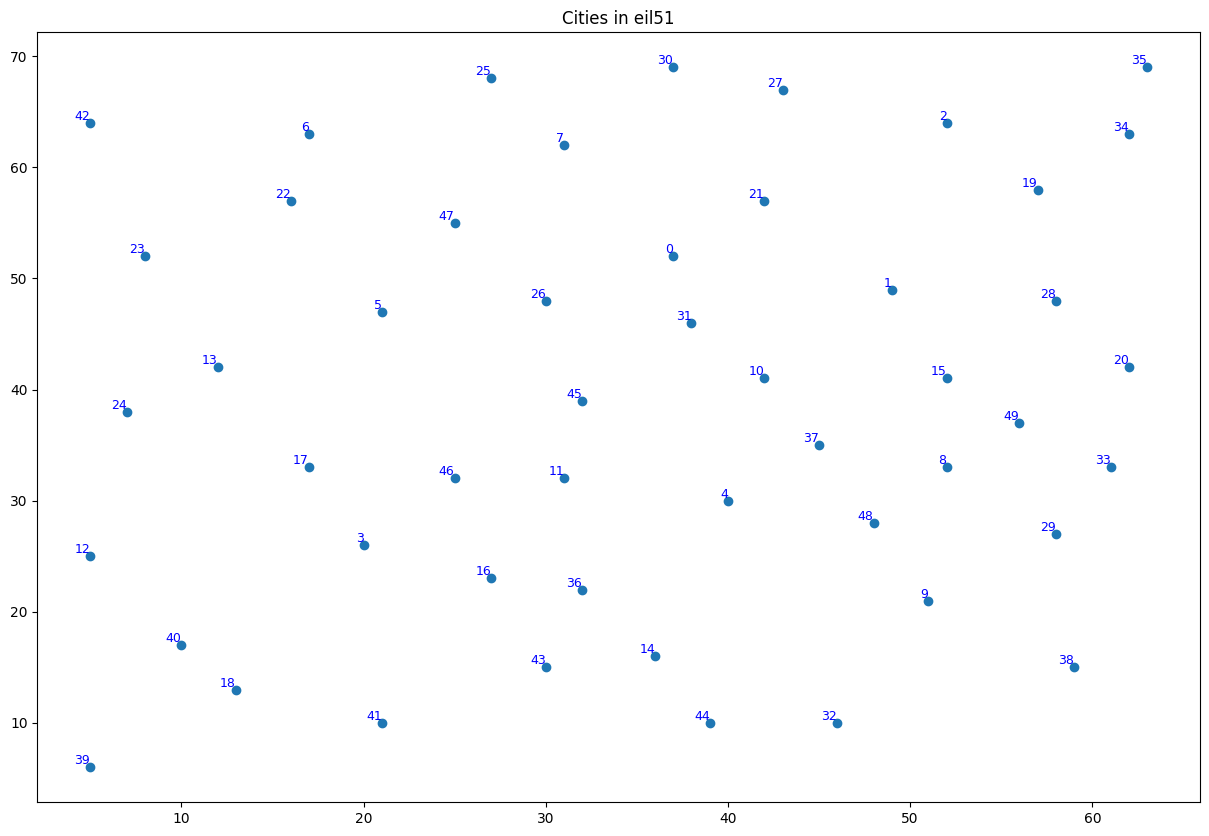

In [47]:
import pyproj as p

x = "eil51"

coord_geo = False
if coord_geo == True:
     crs_wgs = p.Proj(init='epsg:4326')
     crs_bng = p.Proj(init = 'epsg:27700')
    
     tsp_database[x][0],tsp_database[x][1]  = p.transform(crs_wgs, crs_bng, tsp_database[x][1], tsp_database[x][0])
# for x in tsp_database:
print("Problem : " + x)
#    print(tsp_database[x])
X_coord = np.array(tsp_database[x][0])
Y_coord = np.array(tsp_database[x][1])
X_Y = np.array(list(zip(X_coord,Y_coord))).reshape(len(X_coord),2)
plt.figure(figsize=(15,10))
plt.plot()
plt.title('Cities in ' + x)
plt.scatter(X_coord, Y_coord)
for idx, (x1, y1) in enumerate(X_Y):
    plt.text(x1, y1, str(idx), fontsize=9, ha='right', va='bottom', color='blue')
plt.show()


SingleTest Instance Loss: 0.3648, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


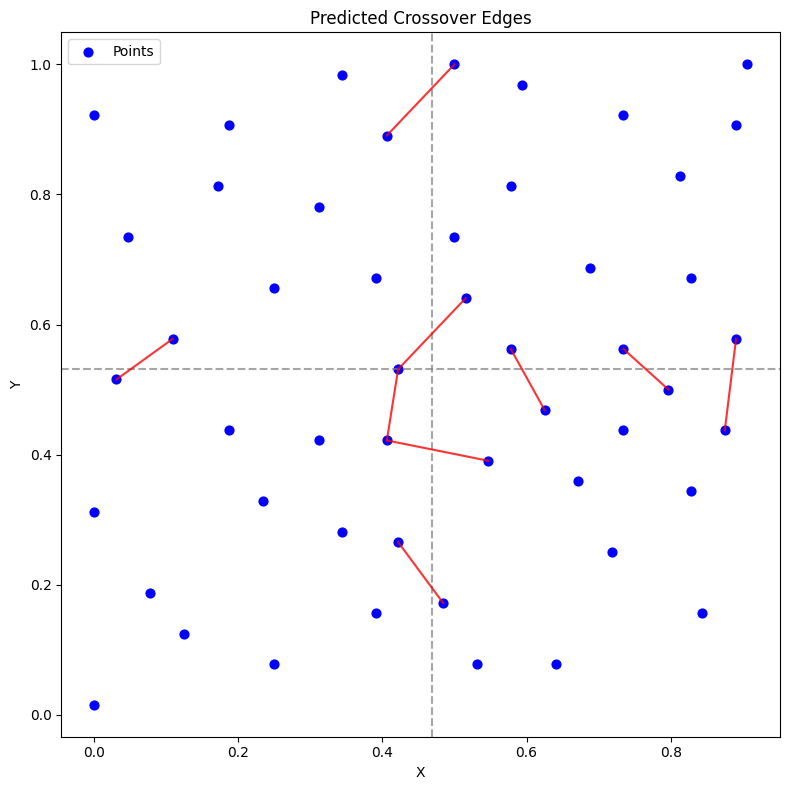

In [48]:
from numpy import inf

X_Y[X_Y == inf] = 0

X_Y_min = np.min(X_Y)
X_Y_max = np.max(X_Y)
X_Y = (X_Y - X_Y_min)/(X_Y_max - X_Y_min)

x_mid = np.mean(X_Y[:,0])
y_mid = np.mean(X_Y[:,1])

predicted_pairs = run_inference(
    X_Y,
    x_mid,
    y_mid,
    model,
    device,
)